In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [92]:
df = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Channelview C15-AH115.csv")

df.head(5)

,Unnamed: 0,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
0,0,2001-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-07-03,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2001-07-04,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2001-07-05,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
### Clean the data

# TODO: Linear interpolation instead?
def clean_df(d : pd.DataFrame):
    d=d.dropna()
    del d['Unnamed: 0']
    d = d[~d.isin(['NV']).any(axis=1)]
    return d

df = clean_df(df)

KeyError: 'Unnamed: 0'

In [35]:
x_axis = (matplotlib.dates.datestr2num(df.Date.values))

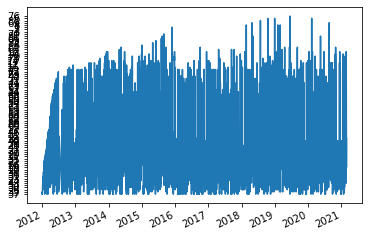

In [36]:
plt.plot_date(x_axis, df.AQI.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

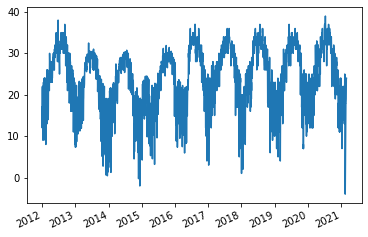

In [5]:
plt.plot_date(x_axis, df.air_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

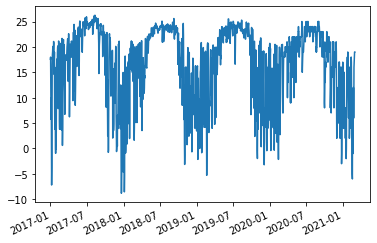

In [13]:
plt.plot_date(x_axis, df.dew_point_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

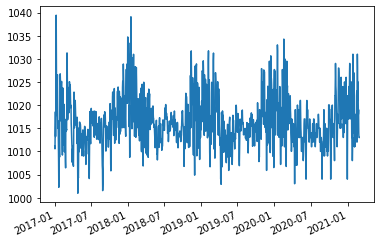

In [14]:
plt.plot_date(x_axis, df.sea_level_pressure.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

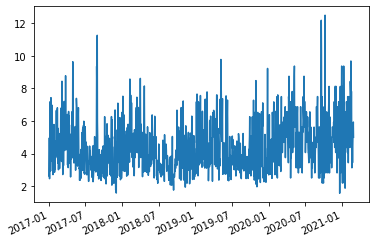

In [15]:
plt.plot_date(x_axis, df.wind_speed.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

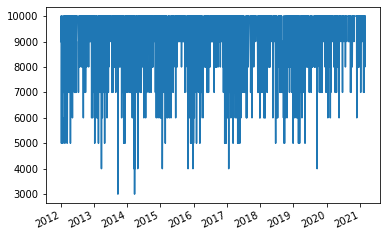

In [6]:
plt.plot_date(x_axis, df.visibility.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

In [37]:
x_data = df[['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed']].values
y_data = df.AQI.values

print(x_data)

[[1.7000e+01 9.0000e+00 1.0270e+03 6.2500e+00]
 [1.5000e+01 1.0000e+00 1.0350e+03 5.0000e+00]
 [1.2000e+01 0.0000e+00 1.0330e+03 4.0625e+00]
 ...
 [2.3000e+01 1.7000e+01 1.0140e+03 4.3750e+00]
 [2.4000e+01 1.8000e+01 1.0140e+03 4.3750e+00]
 [2.4000e+01 1.9000e+01 1.0140e+03 4.3750e+00]]


In [38]:
train_test_split = 0.8

num_train = int(len(x_data) * train_test_split)
num_test = len(x_data) - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

# Expanding dimension to (None, 1) (to a vector) instead of just an array of shape (None,)
# Used in order to feed into the MinMaxScaler (does not support 1D arrays)
y_train = np.expand_dims(y_data[:num_train], axis=1)
y_test = np.expand_dims(y_data[num_train:], axis=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(type(y_train))

(2592, 4) (648, 4) (2592, 1) (648, 1)
<class 'numpy.ndarray'>


In [39]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(y_train)

[['37']
 ['39']
 ['37']
 ...
 ['29']
 ['48']
 ['48']]


In [40]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input features
        x_shape = (batch_size, sequence_length, x_train.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [41]:
batch_size = 32
# 7 days in a week, 8 times
sequence_length = 7 * 16

generator = batch_generator(batch_size, sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape, y_batch.shape)

(32, 112, 4) (32, 112, 1)


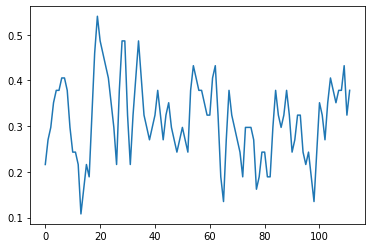

In [42]:
plt.plot(x_batch[0, :, 2])


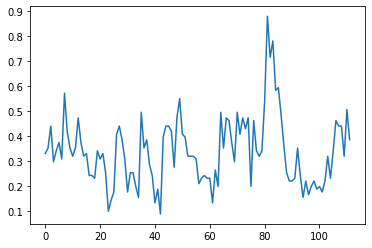

In [43]:
plt.plot(y_batch[1, :, 0])

In [44]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [69]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, x_test.shape[1],)))
model.add(Dense(1, activation='sigmoid')) # TODO change this

In [70]:
warmup_steps = 12

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [71]:
model.compile(loss=loss_mse_warmup, optimizer=RMSprop(lr=1e-3))

/home/jose/.local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [72]:
path_checkpoint = '../weights/checkpoints_weather_non_nan/'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [73]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [74]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [75]:
callbacks = [callback_early_stopping,
             callback_reduce_lr]

In [76]:
model.fit(x=generator,
            epochs=20,
            steps_per_epoch=100,
            validation_data=validation_data,
            callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 5s 40ms/step - loss: 0.0198 - val_loss: 0.0146
Epoch 2/20
100/100 [==============================] - 4s 39ms/step - loss: 0.0178 - val_loss: 0.0132
Epoch 3/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0183 - val_loss: 0.0125
Epoch 4/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0171 - val_loss: 0.0130

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0146 - val_loss: 0.0121
Epoch 6/20
100/100 [==============================] - 4s 38ms/step - loss: 0.0139 - val_loss: 0.0122

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 7/20
100/100 [==============================] - 4s 41ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 8/20
100/100 [==============================] - 4s 40ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 9/20
100/100 [========================

In [77]:
model.save(path_checkpoint)

INFO:tensorflow:Assets written to: ../weights/checkpoints_weather_non_nan/assets
INFO:tensorflow:Assets written to: ../weights/checkpoints_weather_non_nan/assets


In [78]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 55ms/step - loss: 0.0125


In [79]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(y_true[:, 0], label='true')
    plt.plot(y_pred_rescaled[:, 0], label='pred')
    plt.xlabel('Days')
    plt.ylabel('AQI')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.legend()
    plt.show()

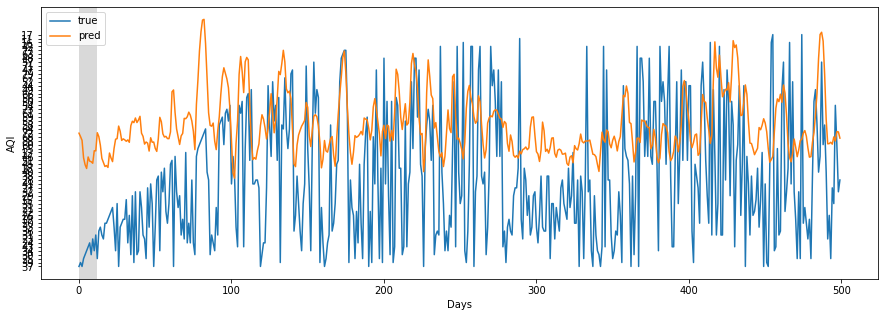

In [80]:
plot_comparison(start_idx=0, length=500, train=True)

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         795648    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 796,161
Trainable params: 796,161
Non-trainable params: 0
_________________________________________________________________


In [101]:
### TRAIN MODEL FOR ALL CSV FILES
base_dir = "/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/"

for csv_file in os.listdir(base_dir):
    print(csv_file)
    try:
        df = pd.read_csv(base_dir + csv_file)
        df = clean_df(df)

        x_data = df[['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed']].values
        y_data = df.AQI.values

        train_test_split = 0.8

        num_train = int(len(x_data) * train_test_split)
        num_test = len(x_data) - num_train

        x_train = x_data[0:num_train]
        x_test = x_data[num_train:]

        # Expanding dimension to (None, 1) (to a vector) instead of just an array of shape (None,)
        # Used in order to feed into the MinMaxScaler (does not support 1D arrays)
        y_train = np.expand_dims(y_data[:num_train], axis=1)
        y_test = np.expand_dims(y_data[num_train:], axis=1)

        x_scaler = MinMaxScaler()
        x_train_scaled = x_scaler.fit_transform(x_train)
        x_test_scaled = x_scaler.transform(x_test)

        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train)
        y_test_scaled = y_scaler.transform(y_test)

        batch_size = 32
        # 7 days in a week, 8 times
        sequence_length = 7 * 4

        gen = batch_generator(batch_size, sequence_length)

        model.compile(loss=loss_mse_warmup, optimizer=RMSprop(lr=1e-3))

        path_checkpoint = '../weights/checkpoints_weather_non_nan/'
        callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_weights_only=True,
                                            save_best_only=True)

        callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

        callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
            factor=0.1,
            min_lr=1e-4,
            patience=0,
            verbose=1)
        callbacks = [callback_early_stopping,
             callback_reduce_lr]

        model.fit(x=gen,
                epochs=20,
                steps_per_epoch=100,
                validation_data=validation_data,
                callbacks=callbacks)
    except ValueError:
        print('Skipping bad data')    

Houston Harvard Street C417.csv
Epoch 1/20
/home/jose/.local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
100/100 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 0.0275
Epoch 2/20
100/100 [==============================] - 1s 12ms/step - loss: 2.9315e-04 - val_loss: 0.0266
Epoch 3/20
100/100 [==============================] - 1s 12ms/step - loss: 1.9511e-04 - val_loss: 0.0246
Epoch 4/20
100/100 [==============================] - 1s 12ms/step - loss: 1.4783e-04 - val_loss: 0.0244
Epoch 5/20
100/100 [==============================] - 1s 13ms/step - loss: 1.1770e-04 - val_loss: 0.0244
Epoch 6/20
100/100 [==============================] - 1s 13ms/step - loss: 9.7395e-05 - val_loss: 0.0246
Epoch 7/20
100/100 [==============================] - 1s 13ms/step - loss: 7.8290e-05 - val_loss: 0.0252
Epoch 8/20
100/100 [=====================

KeyError: "None of [Index(['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed'], dtype='object')] are in the [columns]"

In [109]:
test = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Oyster Creek C1607.csv")
test =clean_df(test)
x_data = test[['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed']].values